# Let's try and model the inspiral frequency of our hybrid dataset

In [1]:
import sympy
# sympy.init_printing()
# x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

# x_sym: generic name I use for independent variables for sympy
x_sym = sympy.symbols('x_sym')

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

In [3]:
import pandas as pd
import pathlib
import h5py
import tqdm

import prim.waveform

In [89]:
import sklearn

In [4]:
import numpy as np

In [5]:
# custom
import phenom
import prim.taylort3

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import prim.collocation

In [7]:
import matplotlib.pyplot as plt
import scienceplots
# plt.style.use(['default'])
# plt.style.use(['science', 'notebook', 'bright'])
plt.style.use(['science', 'notebook', 'muted'])

# plt.style.use(['science', 'notebook', 'grid'])

plt.rcParams['text.usetex'] = False

In [8]:
def load_hybrid_h5_file(hybrid_file, return_metadata=False):
    with h5py.File(hybrid_file, 'r') as f:
        hybrid_metadata = list(f.attrs.items())+[('filename', hybrid_file)]

        times = f['times'][:]
        hlms={}
        for l,m in f.attrs['modes']:
            hlms[l,m] = f[f"hlm_l{l}_m{m}"][:]

        hybrid_wf = prim.waveform.Waveform(times, hlms)

    if return_metadata:
        return hybrid_metadata, hybrid_wf
    else:
        return hybrid_wf

In [9]:
hybrid_data_dir = pathlib.Path("/scratch/sebastian.khan/data/ppmHM_2024_11_11")

In [10]:
df = pd.read_csv(hybrid_data_dir / "metadata.csv")

In [11]:
df

approximant     chi1z     chi2z  is_reference  \
0        SEOBNRv5HM -0.400075 -0.799056          True   
1        SEOBNRv5HM  0.390150 -0.479875         False   
2        SEOBNRv5HM  0.899737  0.899737         False   
3        SEOBNRv5HM -0.775210 -0.799591         False   
4        SEOBNRv5HM -0.600309  0.799911         False   
...             ...       ...       ...           ...   
3115  SEOBNRv4HM_PA -0.399917  0.799417         False   
3116  SEOBNRv4HM_PA -0.000025 -0.400096         False   
3117  SEOBNRv4HM_PA  0.199951 -0.000052         False   
3118     SEOBNRv5HM -0.603632 -0.752452         False   
3119  SEOBNRv4HM_PA -0.599968 -0.000010         False   

                                                  modes         q  \
0     [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  5.997690   
1     [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  1.203005   
2                       [[2 2]\n [3 2]\n [4 4]\n [5 4]]  1.000000   
3     [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  1.329659   
4     [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  1.249881   
...                                                 ...       ...   
3115  [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  5.998540   
3116  [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  1.250001   
3117  [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  1.000000   
3118  [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  7.997162   
3119  [[2 2]\n [2 1]\n [3 3]\n [3 2]\n [4 4]\n [4 3]...  1.000019   

           sxs_sim_name                                           filepath  \
0     SXS:BBH:2212/Lev3  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
1     SXS:BBH:0312/Lev2  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
2     SXS:BBH:0160/Lev3  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
3     SXS:BBH:1471/Lev3  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
4     SXS:BBH:0503/Lev2  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
...                 ...                                                ...   
3115  SXS:BBH:2209/Lev3  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
3116  SXS:BBH:0464/Lev2  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
3117  SXS:BBH:0366/Lev3  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
3118  SXS:BBH:1423/Lev2  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   
3119  SXS:BBH:2090/Lev3  /scratch/sebastian.khan/data/ppmHM_2024_11_11/...   

                           hybrid_name  q_rounded  chi1z_rounded  \
0        SXS_BBH_2212-Lev3__SEOBNRv5HM      5.998         -0.400   
1        SXS_BBH_0312-Lev2__SEOBNRv5HM      1.203          0.390   
2        SXS_BBH_0160-Lev3__SEOBNRv5HM      1.000          0.900   
3        SXS_BBH_1471-Lev3__SEOBNRv5HM      1.330         -0.775   
4        SXS_BBH_0503-Lev2__SEOBNRv5HM      1.250         -0.600   
...                                ...        ...            ...   
3115  SXS_BBH_2209-Lev3__SEOBNRv4HM_PA      5.999         -0.400   
3116  SXS_BBH_0464-Lev2__SEOBNRv4HM_PA      1.250         -0.000   
3117  SXS_BBH_0366-Lev3__SEOBNRv4HM_PA      1.000          0.200   
3118     SXS_BBH_1423-Lev2__SEOBNRv5HM      7.997         -0.604   
3119  SXS_BBH_2090-Lev3__SEOBNRv4HM_PA      1.000         -0.600   

      chi2z_rounded   chi_eff  chi_eff_rounded   ID  
0            -0.799 -0.457091          -0.4571    0  
1            -0.480 -0.004776          -0.0048  254  
2             0.900  0.899737           0.8997  320  
3            -0.800 -0.785675          -0.7857   42  
4             0.800  0.022044           0.0220  195  
...             ...       ...              ...  ...  
3115          0.799 -0.228548          -0.2285   45  
3116         -0.400 -0.177834          -0.1778  345  
3117         -0.000  0.099949           0.0999   18  
3118         -0.752 -0.620173          -0.6202  118  
3119         -0.000 -0.299992          -0.3000   11  

[3120 rows x 15 columns]

# Another attempt

In [12]:
# we can apply an affine transformation
# to the PN inspiral portion
# of the waveform in order to
# get the data in the appropriate
# form for the PN-like ansatz

def transformation_affine_foward(x, a=1, b=0):
    """
    return y=a*x + b
    """
    return a*x + b

def transformation_affine_reverse(y, a=1, b=0):
    """
    return x=(y-b)/a
    """
    return (y-b)/a

        
def get_taylort3_inspiral_omega_affine_params(t, tc, eta, M, chi1, chi2):
    """
    get inspiral angular GW frequency TaylorT3 Newtonian term
    and TaylorT3 approximation
    
    returns: Newtonaian Term and Full TaylorT3 approximation
    """
    omega_N = prim.taylort3.TaylorT3_Omega_GW_Newt(t, tc, eta, M)
    omega_pn = prim.taylort3.TaylorT3_Omega_GW(t, tc, eta, M, chi1, chi2)
    return omega_N, omega_pn

In [13]:
class CollocationPointFitter:
    def __init__(self, waveform, metadata, mode, tc=0, M=1):
        self.metadata = metadata
        self.mode = mode
        self.tc = tc
        self.M = M

        # need q_rounded so that we don't get things like 0.25000001 which can cause NaN in PN
        self.q = self.metadata['q_rounded']
        self.eta = phenom.eta_from_q(self.q)
        self.chi1 = self.metadata['chi1z']
        self.chi2 = self.metadata['chi2z']

        x = waveform.times
        y = waveform.frequencies[self.mode]
        # correct for convention
        y = -y

        y_transformed = self.transform_y(x, y)

        # self.collocation_points = 
        # self.rhs = 

        # self.ansatz =

        # self.cm = collocation.CollocationModel(self.collocation_points, self.rhs, self.ansatz)

    def transform_y(self, x, y):
        #
        # PN parameters
        pn_kwargs=dict(t=x, tc=self.tc, eta=self.eta, M=self.M)
        # Get PN transformation variables
        self.omega_N, self.omega_pn = get_taylort3_inspiral_omega_affine_params(x, self.tc, self.eta, self.M, self.chi1, self.chi2)
         # apply tranformation
        y_transformed = transformation_affine_reverse(y, self.omega_N, self.omega_pn)

        return y_transformed

In [14]:
hybrid_wf = load_hybrid_h5_file(df.loc[0, 'filepath'])

In [15]:
hybrid_wf.compute_frequency()

In [16]:
hybrid_wf.times

array([-63671.7812702 , -63671.47147796, -63671.16168572, ...,
          192.81873149,    193.12852373,    193.43831597])

In [17]:
hybrid_wf.frequencies[2,2]

array([-1.53242485e-02, -1.53242486e-02, -1.53242488e-02, ...,
        7.33955357e-13,  1.00918862e-12, -1.10093304e-12])

In [23]:
%%time
iffs = []
# idxs = df[df['chi_eff_rounded'] == 0].index
idxs = df.index[::10]
# idxs = df.index
dof = 4
for i in tqdm.trange(len(idxs)):
    idx = idxs[i]
    hybrid_wf = load_hybrid_h5_file(df.loc[idx, 'filepath'])
    hybrid_wf.modes = [(2,2)]
    hybrid_wf.compute_frequency()


    # iffs.append(CollocationPointFitter(hybrid_wf, df.loc[idx], (2,2)))


100%|██████████| 312/312 [00:41<00:00,  7.57it/s]

CPU times: user 16.9 s, sys: 4.07 s, total: 21 s
Wall time: 41.2 s


In [19]:
# #
# # In this example we will use two collocation points at the boundary of our
# # data i.e. x=0 and x=1 as well as one at the midpoint x=0.5.
# # We will also use two 1st order derivative collocation points at the boundary.
# collocation_points = {0: [0, 0.5, 1], 1: [0, 1]}
# # collocation_points = {0:[0, 1], 1:[0, 1], 2:[1]}
# #
# # The collocation point values are stored in a dictionary called rhs_true
# # which stands for "right hand side" and the true means it's our estimate of these values
# # from the data.
# rhs_true = {
#     d: [iy.derivative(d)(v) for v in collocation_points[d]] for d in collocation_points.keys()
# }

# # The final thing we need to specify is the ansatz (also called model or functional form).
# # THis is a linear model with the same number of coefficients as there are collocation points.
# # Here we use a 4th order polynomial in x.
# # We define the ansatz using `sympy`.
# ansatz = sum([x_sym**p for p in range(5)])

# # We are now ready to define our collocation point model and fit the model to the data.
# cm = collocation.CollocationModel(collocation_points, rhs_true, ansatz)

# Old and Slow: Compute inspiral frequency collocation points

https://gitlab.com/SpaceTimeKhantinuum/ml/-/blob/master/waveforms/oct2022/uncertainty/nr_only/scratch_2/inspiral-freq-model.ipynb

and

https://gitlab.com/SpaceTimeKhantinuum/ml/-/blob/master/waveforms/sept2024/test-inspiral-modelling.ipynb

In [24]:
# we can apply an affine transformation
# to the PN inspiral portion
# of the waveform in order to
# get the data in the appropriate
# form for the PN-like ansatz

def transformation_affine_foward(x, a=1, b=0):
    """
    return y=a*x + b
    """
    return a*x + b

def transformation_affine_reverse(y, a=1, b=0):
    """
    return x=(y-b)/a
    """
    return (y-b)/a

        
def get_taylort3_inspiral_omega_affine_params(t, tc, eta, M, chi1, chi2):
    """
    get inspiral angular GW frequency TaylorT3 Newtonian term
    and TaylorT3 approximation
    
    returns: Newtonaian Term and Full TaylorT3 approximation
    """
    omega_N = prim.taylort3.TaylorT3_Omega_GW_Newt(t, tc, eta, M)
    omega_pn = prim.taylort3.TaylorT3_Omega_GW(t, tc, eta, M, chi1, chi2)
    return omega_N, omega_pn
        

def prepare_fit_data(waveform, t_start, t_end, target, dt=None, mode=(2,2)):
    """
    waveform: instance of waveform
    t_start, t_end: float. start and end times that the returned data will cover
    target: str. name of target attribute to model e.g. 'amp', 'phase', 'freq'
    """
    # eta = waveform.eta
    times = waveform.times
    mask = (times >= t_start) & (times <= t_end)

    t = times[mask]
    # y = waveform.__getattribute__(target)
    y = waveform.__getattribute__(target)[mode]
    y = y[mask]

    if dt != None:
        # interpolate with new spacing
        t_new = np.arange(t[0], t[-1], dt)
        y = IUS(t, y)(t_new)
        t = t_new
        
    return t, y

In [25]:
class InspiralFrequencyFitter:
    def __init__(self, mode, metadata, tc=0, M=1, dt=None, dof=4):
        self.mode = mode
        self.metadata = metadata
        self.tc = tc
        self.M = M
        self.dt = dt
        self.dof = dof

        self.cps = np.linspace(0.42, 0.8, self.dof)
        self.base_ansatz = np.sum([x_sym**(8+i) for i in range(self.dof)])

        # need q_rounded so that we don't get things like 0.25000001 which can cause NaN in PN
        self.q = self.metadata['q_rounded']
        self.eta = phenom.eta_from_q(self.q)
        self.chi1 = self.metadata['chi1z']
        self.chi2 = self.metadata['chi2z']

        self.theta_cp_fixed = prim.taylort3.TaylorT3_theta(-200, self.tc, self.eta, self.M)
        self.cps[-1] = self.theta_cp_fixed

        self.collocation_points_theta = {
            0:self.cps,
        }

        self.collocation_points_M = {}
        for k in self.collocation_points_theta:
            self.theta_array = np.array(self.collocation_points_theta[k])
            self.collocation_points_M[k] = prim.taylort3.TaylorT3_t(self.theta_array, self.tc, self.eta, self.M)   


    def prepare(self, waveform):
        # Time range avaiable to use for fitting and testing
        self.pad = 20
        self.t_start = self.collocation_points_M[0][0] - self.pad
        # t_start = -80000
        # self.t_start = waveform.times[0]
        self.t_end = self.collocation_points_M[0][-1] + self.pad


        x, self.y = prepare_fit_data(waveform, self.t_start, self.t_end, 'frequencies', dt=self.dt, mode=self.mode)
        # NOTE: swap sign because my PN taylort3 has opposite sign... very important
        self.y = -self.y
        
        #
        # PN parameters
        pn_kwargs=dict(t=x, tc=self.tc, eta=self.eta, M=self.M)
        # Get PN transformation variables
        self.omega_N, self.omega_pn = get_taylort3_inspiral_omega_affine_params(x, self.tc, self.eta, self.M, self.chi1, self.chi2)
         # apply tranformation
        y_transformed = transformation_affine_reverse(self.y, self.omega_N, self.omega_pn)

        # prepare ansatz
        theta = prim.taylort3.TaylorT3_theta(x_sym, self.tc, self.eta, self.M)
        pn_sub_dict = {'x_sym': theta}
        self.ansatz = self.base_ansatz.subs(pn_sub_dict)
        self.sub_dict={}

        self.x = x
        self.y_transformed = y_transformed

        self.x_theta = prim.taylort3.TaylorT3_theta(self.x, self.tc, self.eta, self.M)


    def fit(self, hybrid):        
        self.prepare(hybrid)
        
        self.collocation_points = self.collocation_points_M
        # self.rhs_override = rhs_override
        

        # interpolate target so we can evaluate
        # it and it's derivative at any x value
        self.iy_transformed = IUS(self.x, self.y_transformed)
        
        # evaluate interpolant at corresponding derivative order
        # and location
        self.rhs = {}
        for k in self.collocation_points.keys():
            v = map(self.iy_transformed.derivative(k), self.collocation_points[k])
            v = np.array(list(v))
            self.rhs[k] = v
            
        self.cm = prim.collocation.CollocationModel(
            collocation_points=self.collocation_points,
            collocation_values=self.rhs,
            ansatz=self.ansatz,
            sub_dict=self.sub_dict,
        )
        
        


In [26]:
hybrid_wf = load_hybrid_h5_file(df.loc[0, 'filepath'])

In [27]:
hybrid_wf.compute_frequency()

In [28]:
hybrid_wf.times[1] - hybrid_wf.times[0]

0.30979224169277586

In [29]:
hybrid_wf.times.shape

(206156,)

In [30]:
iff = InspiralFrequencyFitter((2,2), df.loc[0], dt=10)

In [31]:
iff.fit(hybrid_wf)

In [32]:
iff.cm.collocation_points_1d

array([-42161.60120063,  -5118.3581596 ,   -966.20771602,   -200.        ])

In [33]:
iff.cm.rhs_1d

array([0.0216334 , 0.15455533, 0.68815772, 2.64817844])

In [34]:
yhat = iff.cm.predict(iff.x)

In [35]:
iff.x.shape

(4201,)

In [36]:
iff.x[1] - iff.x[0]

10.0

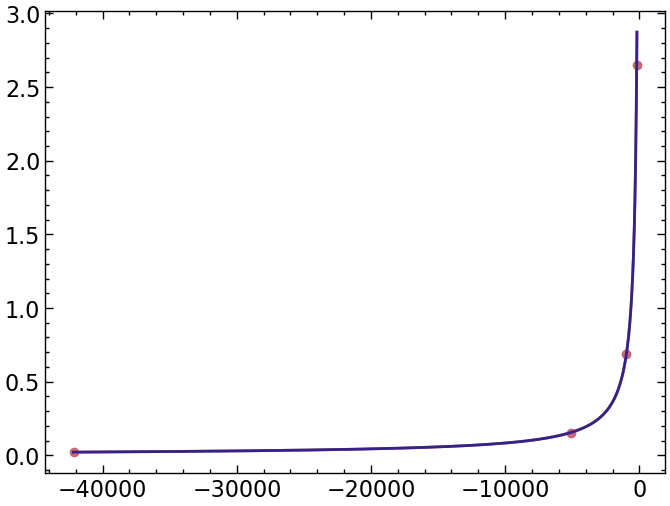

In [37]:
plt.plot(iff.x, iff.y_transformed)
plt.scatter(iff.cm.collocation_points_1d, iff.cm.rhs_1d)
plt.plot(iff.x, yhat)

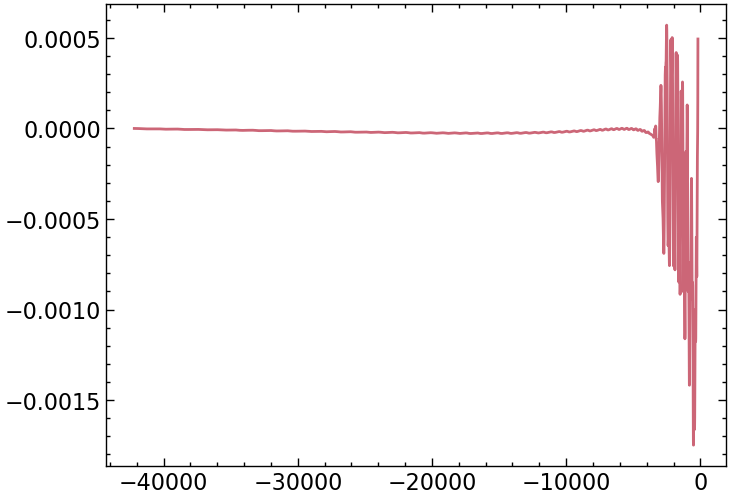

In [38]:
plt.plot(iff.x, iff.y_transformed-yhat)

In [39]:
df.shape

(3120, 15)

In [40]:
df[df['chi_eff_rounded'] == 0].index

Index([  11,   25,   27,   28,   33,   42,   47,   58,   80,   86,
       ...
       3068, 3069, 3074, 3079, 3081, 3082, 3089, 3098, 3109, 3111],
      dtype='int64', length=394)

In [41]:
df[df['chi_eff_rounded'] == 0].shape

(394, 15)

In [42]:
hybrid_wf.times[::10].shape

(20616,)

In [43]:
df.shape

(3120, 15)

In [44]:
# idx=0
# hybrid_wf = load_hybrid_h5_file(df.loc[idx, 'filepath'])

# # hack to speed up the code, because `hybrid_wf.compute_frequency()`
# # by default loops over all modes
# # hmm still takes a long time :()
# # print(hybrid_wf.modes)
# # hybrid_wf.modes = [(2,2)]

In [45]:
%%time
iffs = []
# idxs = df[df['chi_eff_rounded'] == 0].index
idxs = df.index[::10]
# idxs = df.index
dof = 4
for i in tqdm.trange(len(idxs)):
    idx = idxs[i]
    hybrid_wf = load_hybrid_h5_file(df.loc[idx, 'filepath'])


    # hack to speed up the code, because `hybrid_wf.compute_frequency()`
    # by default loops over all modes
    # hmm still takes a long time :()
    # print(hybrid_wf.modes)
    hybrid_wf.modes = [(2,2)]

    hybrid_wf.times = hybrid_wf.times[::10]
    for k in hybrid_wf.modes:
        hybrid_wf.hlms[k] = hybrid_wf.hlms[k][::10]
    
    hybrid_wf.compute_frequency()
    iff = InspiralFrequencyFitter((2,2), df.loc[idx], dof=dof, dt=10)
    iff.fit(hybrid_wf)
    iffs.append(iff)

100%|██████████| 312/312 [00:13<00:00, 22.87it/s]

CPU times: user 11.4 s, sys: 2 s, total: 13.4 s
Wall time: 13.6 s


In [46]:
# save these with cloudpickle?

In [47]:
iffs[0]

In [48]:
coeffs = np.array([iff_.cm.rhs_1d for iff_ in iffs])

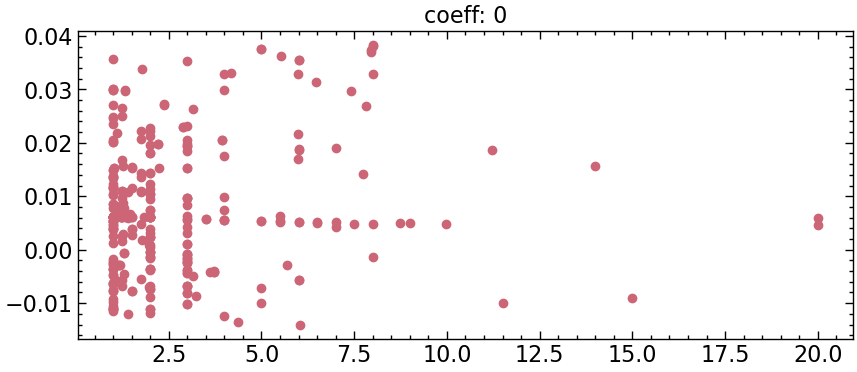

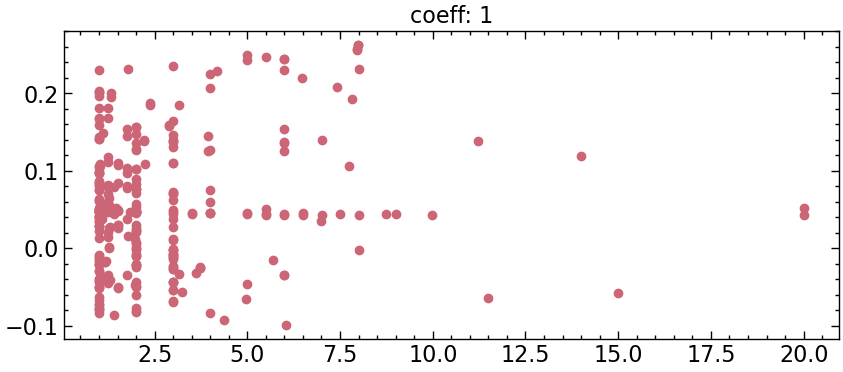

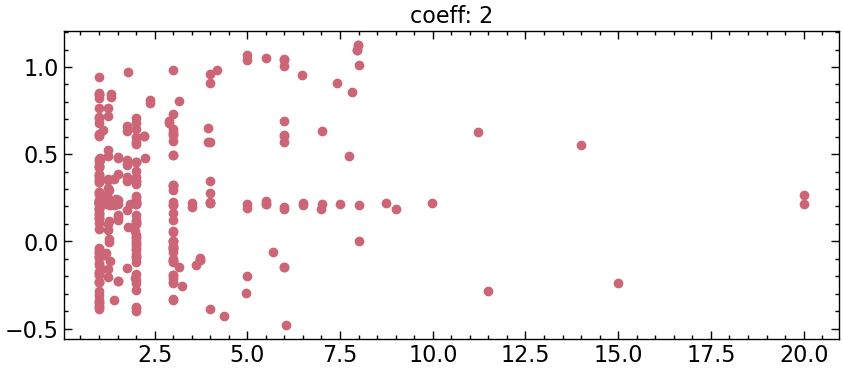

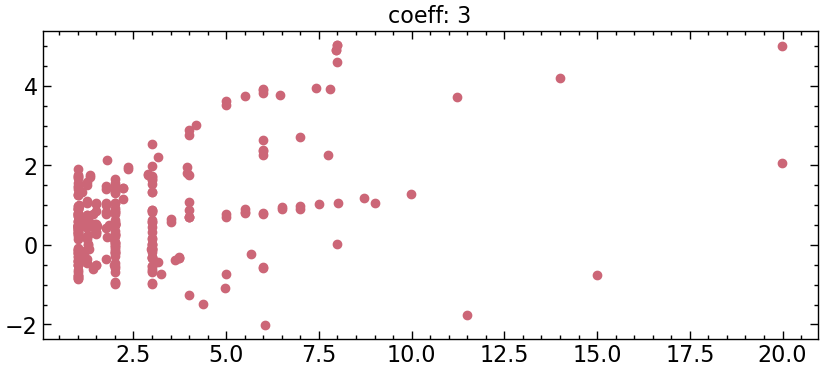

In [49]:
for i in range(dof):
    plt.figure(figsize=(10, 4))
    plt.scatter(df.iloc[idxs]['q'], coeffs[:, i])
    plt.title(f"coeff: {i}")
    plt.show()
    plt.close()

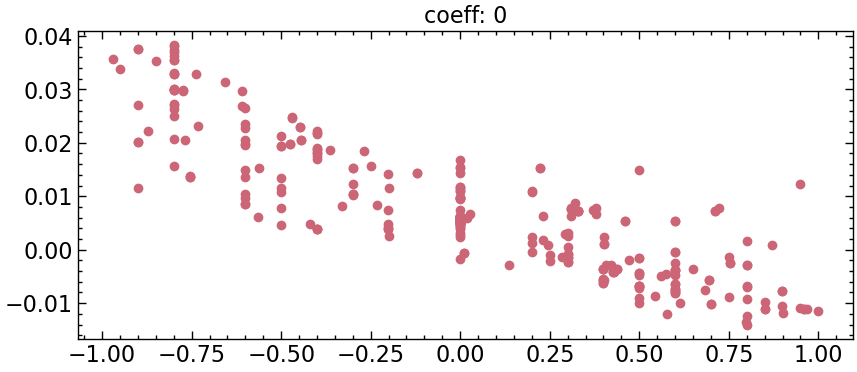

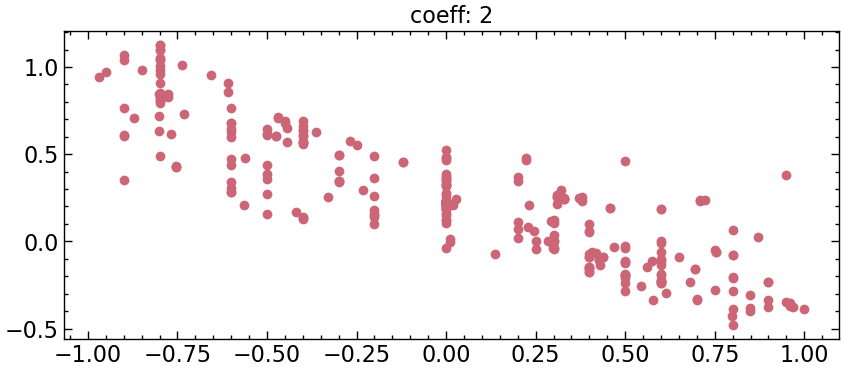

In [50]:
for i in range(dof):
    plt.figure(figsize=(10, 4))
    plt.scatter(df.iloc[idxs]['chi1z'], coeffs[:, i])
    plt.title(f"coeff: {i}")
    plt.show()
    plt.close()

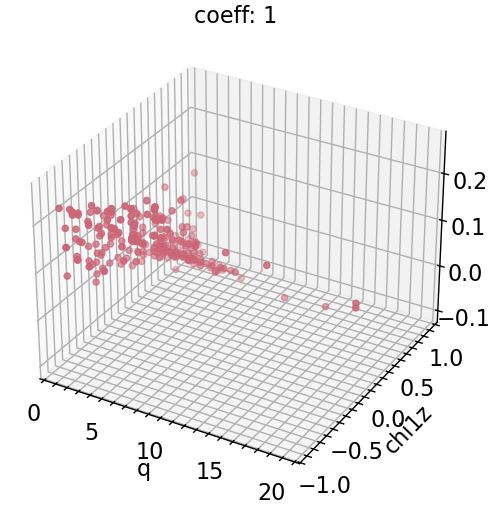

In [51]:
for i in range(dof):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(df.iloc[idxs]['q'], df.iloc[idxs]['chi1z'], coeffs[:, i])
    ax.set_title(f"coeff: {i}")
    ax.set_xlabel("q")
    ax.set_ylabel("chi1z")
    
    plt.show()
    plt.close()

# fit eqr

In [52]:
from eqr.epistemic_quantile_regressor import EpistemicQuantileRegressor


In [595]:
df['eta'] = phenom.eta_from_q(df['q_rounded'])
X = df.iloc[idxs][['q_rounded', 'chi1z', 'chi2z']].values
y = coeffs[:,0]

In [596]:
X.shape

(312, 3)

In [597]:
# np.save('X.npy', X)
# np.save('y.npy', coeffs)

In [598]:
X.min(0)

array([ 1.        , -0.96924273, -0.96924273])

In [599]:
X.max(0)

array([19.996     ,  0.99800073,  0.99800076])

In [600]:
# method = "gbr"
method = "ann"
# method = "lgb"
eqr_model = EpistemicQuantileRegressor([(1, 30), (-1, 1), (-1, 1)], 1000, method=method)

In [601]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((218, 3), (94, 3), (218,), (94,))

In [602]:
ood_method = 'generative'
# ood_method = 'convex_hull'

In [603]:
if ood_method == 'generative':
    
    # build OOD based on all data? or just X_train?
    X_ood, y_ood = eqr_model.generate_synthetic_ood_data(
        X,
        y,
        scaling_factor=5,
        gm_kwargs={"n_components": 3},
    )
    
    # only add OOD to X_train
    X_aug, y_aug = eqr_model.augment_training_data(X_train, y_train, X_ood, y_ood)
    
    
    print(X.shape, X_ood.shape, X_aug.shape)

elif ood_method == 'convex_hull':
    from scipy.spatial import ConvexHull, convex_hull_plot_2d
    # simple way to select points in/out the hull
    # but this only works for 2D!
    # https://stackoverflow.com/a/31404895/12840171
    from matplotlib.path import Path
    # points = X_train[:,:2]
    points = X_train
    hull = ConvexHull(points)

    D = len(eqr_model.synthetic_data_domain)
    min_values = [v[0] for v in eqr_model.synthetic_data_domain]
    max_values = [v[1] for v in eqr_model.synthetic_data_domain]
    
    xx = np.random.uniform(
        low=min_values, high=max_values, size=(1000, D)
    )

    # https://stackoverflow.com/a/77745898/12840171
    # def points_in_hull(points: np.ndarray, hull: ConvexHull, tolerance: float = 1e-12):
    #     return np.all(np.add(points @ hull.equations[:, :-1].T, hull.equations[:, -1]) <= tolerance, axis=1)

    # https://stackoverflow.com/a/72483841/12840171
    def points_in_hull(p, hull, tol=1e-12):
        return np.all(hull.equations[:,:-1] @ p.T + np.repeat(hull.equations[:,-1][None,:], len(p), axis=0).T <= tol, 0)

    # 2D method
    # hull_path = Path( points[hull.vertices] )
    # is_in_convex_hull = [hull_path.contains_point(p) for p in xx] # Is (x,y) in the convex hull?
    # is_in_convex_hull = np.array(is_in_convex_hull)

    is_in_convex_hull = points_in_hull(xx, hull)
    
    xx = xx[~is_in_convex_hull]
    plt.plot(X_train[:,0], X_train[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(X_train[simplex, 0], X_train[simplex, 1], 'k-')
    
    plt.plot(xx[:,0], xx[:,1], 'o')
else:
    raise ValueError(f"{ood_method = } unknown")

(312, 3) (735, 3) (953, 3)


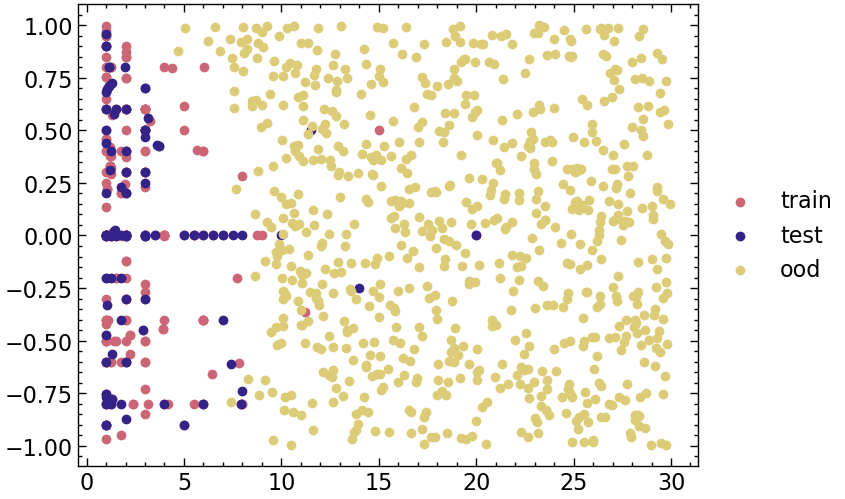

In [604]:
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], label='train')
plt.scatter(X_test[:,0], X_test[:,1], label='test')
plt.scatter(X_ood[:,0], X_ood[:,1], label='ood')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [465]:
X_aug.shape

(639, 3)

In [572]:
%%time
if method == "ann":
    params = dict(epochs=2000, batch_size=32, verbose=0)
elif method == "gbr":
    params = dict(n_trials=100)
elif method == "lgb":
    params = dict(
        n_trials=10,
        # fixed_params={"num_leaves": 31},
        fixed_params={"num_iterations": 100},
        # fixed_params=None,
        search_params=[["num_leaves", "int", 1000, 2000]],
        cv_params={"nfold": 3},
    )
else:
    raise ValueError(f"unknown {method = }")



ss = sklearn.preprocessing.StandardScaler()

# xx = X_train[train_mask_non_spinning,0][:,np.newaxis]
# yy = y_train[train_mask_non_spinning]

xx = X_aug
yy = y_aug

yy_prime = ss.fit_transform(yy[:,np.newaxis])[:,0]

eqr_model.fit(xx, yy_prime, **params)

# eqr_model.fit(X_aug, y_aug, **params)

# eqr_model.fit(X_train[train_mask_non_spinning,0][:,np.newaxis], y_train[train_mask_non_spinning], **params)

CPU times: user 42.2 s, sys: 3.1 s, total: 45.3 s
Wall time: 33.2 s


In [573]:
if method == 'lgb':
    for k in eqr_model.study.keys():
        print(k, eqr_model.study[k].best_params)

In [574]:
if method == 'lgb':
    for k in eqr_model.params.keys():
        print(k, eqr_model.params[k])

In [575]:
yhats_train = eqr_model.predict(X_train)
yhats_test = eqr_model.predict(X_test)

In [576]:
for i in range(len(yhats_train)):
    yhats_train[i] = ss.inverse_transform(yhats_train[i])
    yhats_test[i] = ss.inverse_transform(yhats_test[i])

In [577]:
sklearn.metrics.mean_squared_error(y_train, yhats_train[1])

3.6214678231739037

In [578]:
sklearn.metrics.mean_squared_error(y_test, yhats_test[1])

5.763922775802025

In [579]:
y_train[:10]

array([-0.00677299,  0.01151555,  0.02473296, -0.00615029,  0.00636856,
        0.00533914, -0.00054534, -0.00862415, -0.00679182,  0.0013061 ])

In [580]:
yhats_train[1][:10,0]

array([0.6151715 , 1.1204655 , 2.4167798 , 0.55124587, 0.8031625 ,
       2.45665   , 0.99782926, 1.7362761 , 1.5430306 , 0.54185945],
      dtype=float32)

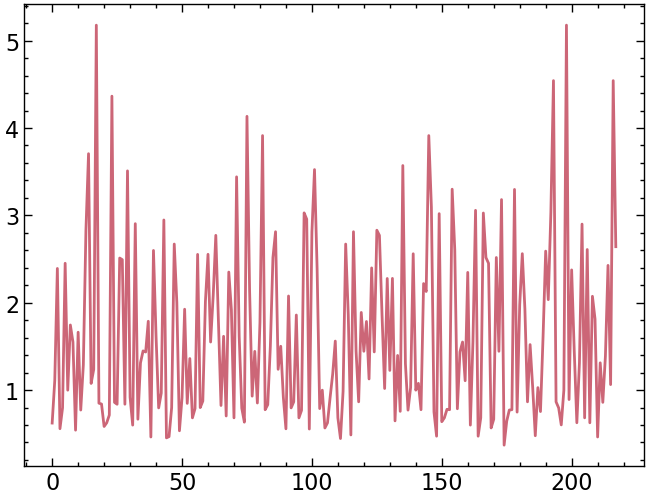

In [581]:
plt.plot((yhats_train[1][:,0] - y_train))
# plt.ylim(-1, 1)

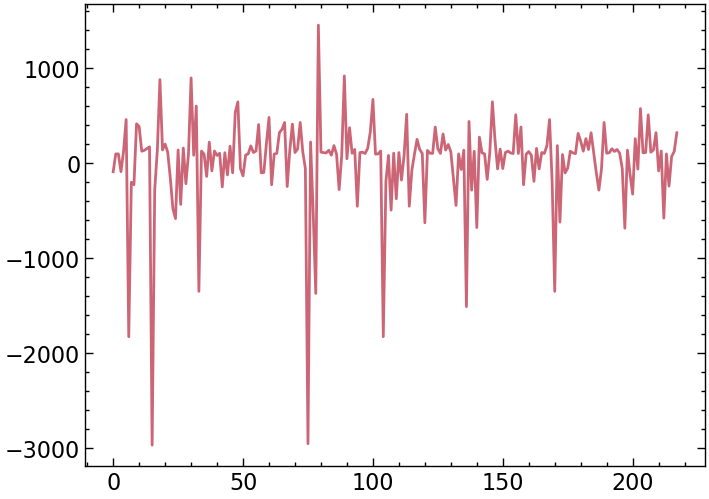

In [582]:
plt.plot((yhats_train[1][:,0] - y_train)/y_train)
# plt.ylim(-1, 1)

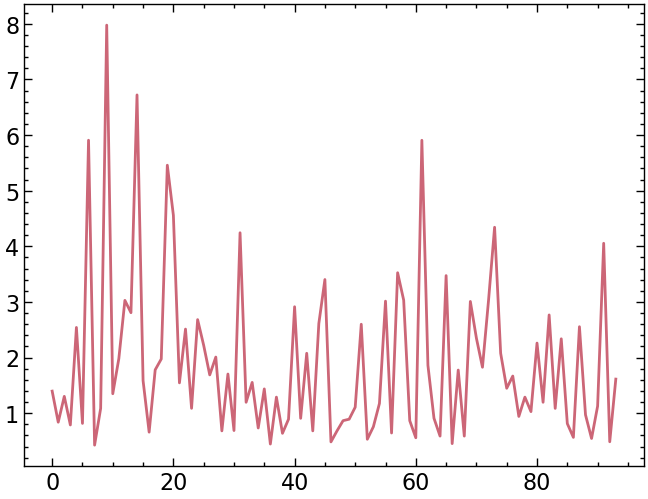

In [583]:
plt.plot((yhats_test[1][:,0] - y_test))
# plt.ylim(-1, 1)

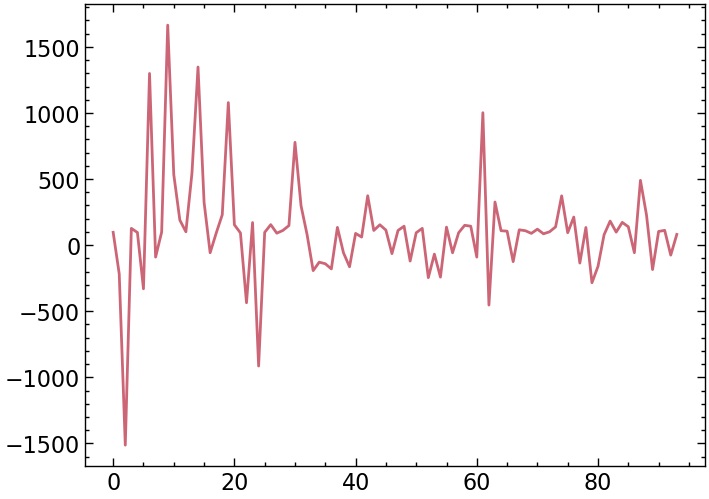

In [584]:
plt.plot((yhats_test[1][:,0] - y_test)/y_test)

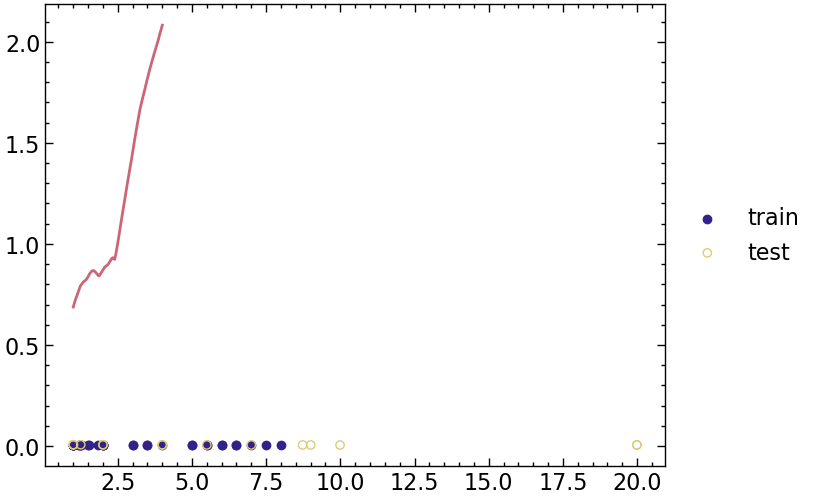

In [585]:
X_non_spinning = np.zeros(shape=(100, 3))
# X_non_spinning[:,0] = np.linspace(0.3, 0.001, 100)
X_non_spinning[:,0] = np.linspace(1, 4, 100)
yhats_ns = eqr_model.predict(X_non_spinning)


for i in range(len(yhats_ns)):
    yhats_ns[i] = ss.inverse_transform(yhats_ns[i])

train_mask_non_spinning = (np.abs(X_train[:,1]) < 1e-3) & (np.abs(X_train[:,2]) < 1e-3)
test_mask_non_spinning = (np.abs(X_test[:,1]) < 1e-3) & (np.abs(X_test[:,2]) < 1e-3)

plt.scatter(X_train[train_mask_non_spinning,0], y_train[train_mask_non_spinning], label='train', c='C1')
plt.scatter(X_test[test_mask_non_spinning,0], y_test[test_mask_non_spinning], label='test', ec='C2', fc='none')
plt.plot(X_non_spinning[:,0], yhats_ns[1][:,0])
# plt.fill_between(X_non_spinning[:,0], yhats_ns[0][:,0], yhats_ns[2][:,0], alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.ylim(-0.1, 0.1)

In [586]:
D = len(eqr_model.synthetic_data_domain)
min_values = [v[0] for v in eqr_model.synthetic_data_domain]
max_values = [v[1] for v in eqr_model.synthetic_data_domain]

# min_values[2]=0
# max_values[2]=0

xx = np.random.uniform(
    low=min_values, high=max_values, size=(1000, D)
)

In [587]:
yhats = eqr_model.predict(xx)

In [588]:
len(yhats)

3

/local/sebastian.khan@ligo.org/ipykernel_1653229/163554458.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


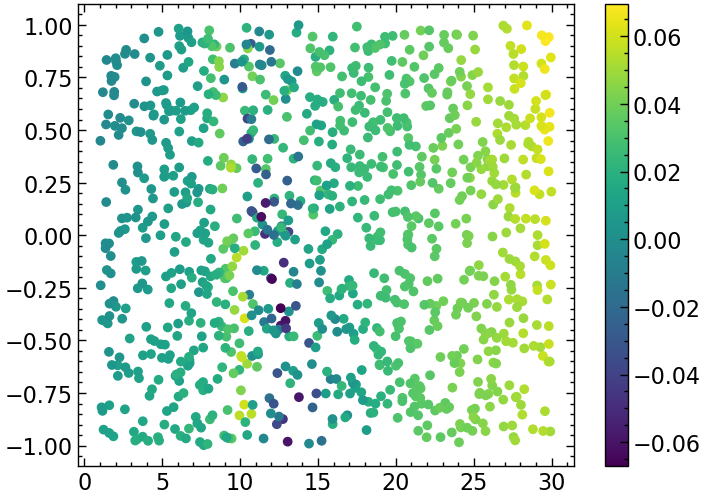

In [589]:
plt.figure()
# plt.scatter(X[:,0], X[:,1], label='train')
# plt.scatter(X_ood[:,0], X_ood[:,1], label='ood')
plt.scatter(xx[:,0], xx[:,1], c=yhats[1][:,0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.colorbar()

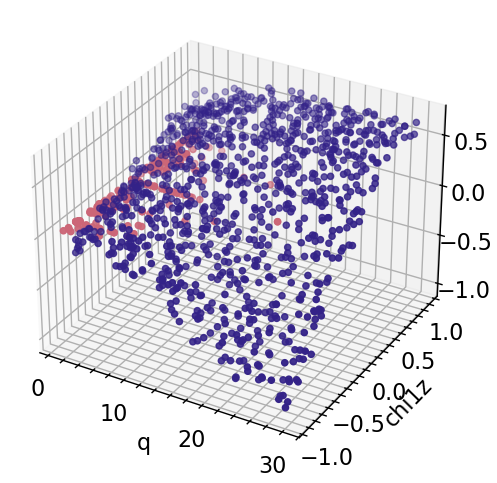

In [482]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], y)

ax.scatter(xx[:,0], xx[:,1], yhats[1][:,0])

ax.set_xlabel("q")
ax.set_ylabel("chi1z")

plt.show()
plt.close()

# fit sklearn

In [211]:
import sklearn.gaussian_process

In [212]:
def fit_coeffs_sklearn(X, y):
    # std_error = y_train.std()
    # kfn = sklearn.gaussian_process.kernels.RBF(1.0 / std_kernel)
    # kfn = sklearn.gaussian_process.kernels.RBF()
    kfn = sklearn.gaussian_process.kernels.RationalQuadratic() + sklearn.gaussian_process.kernels.WhiteKernel()
    gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel=kfn, normalize_y=True)
    gpr.fit(X, y)
    return gpr

In [213]:
df['eta'] = phenom.eta_from_q(df['q_rounded'])

In [214]:
X = df.iloc[idxs][['eta', 'chi1z', 'chi2z']].values
y = coeffs[:,0]


# training set = non-spinning
mask = (np.abs(X[:,1]) < 1e-3) & (np.abs(X[:,2]) < 1e-3)
X_train = X[mask]
y_train = y[mask]

X_test = X[~mask]
y_test = y[~mask]

# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.8)

gpr = fit_coeffs_sklearn(X_train, y_train)
# pred, pstd, pcov = gpr.predict(q_fine, return_std=True, return_cov=True)


In [215]:
X_train.shape

(50, 3)

In [216]:
X_test.shape

(262, 3)

In [217]:
pred, pstd = gpr.predict(X, return_std=True, return_cov=False)

In [229]:
sklearn.metrics.mean_squared_error(y, pred)

0.00014914538951109487

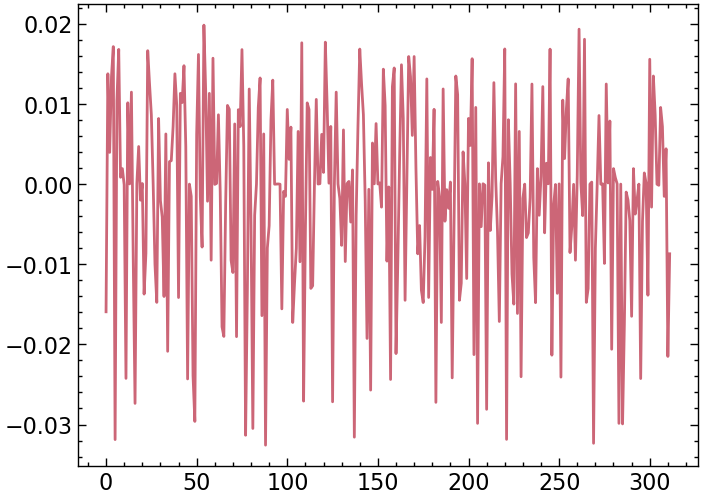

In [218]:
plt.plot((pred - y))

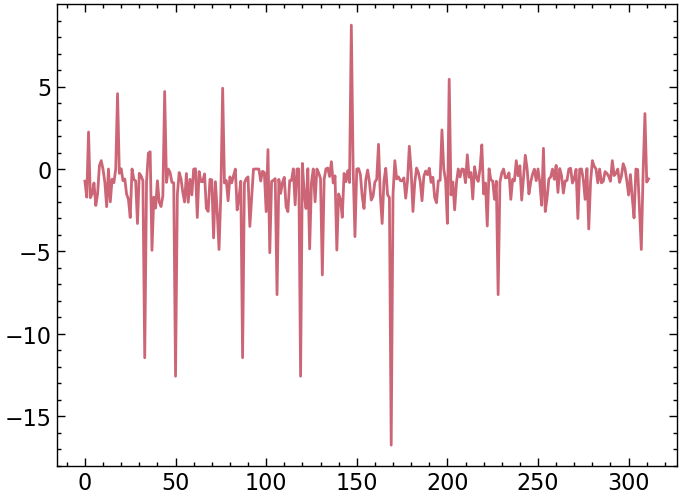

In [219]:
plt.plot((pred - y)/y)

In [220]:
pred_samples = gpr.sample_y(X, 100)

In [221]:
pred_samples.shape

(312, 100)

In [1709]:
# --- x.max
#  |
#  x
#  |
# --- x.min

# x.max - x
# x - x.min
# yerr = [pred_samples.max(1)-pred, pred-pred_samples.min(1)]
# plt.errorbar(X[:,0], pred, fmt='o', yerr=yerr)

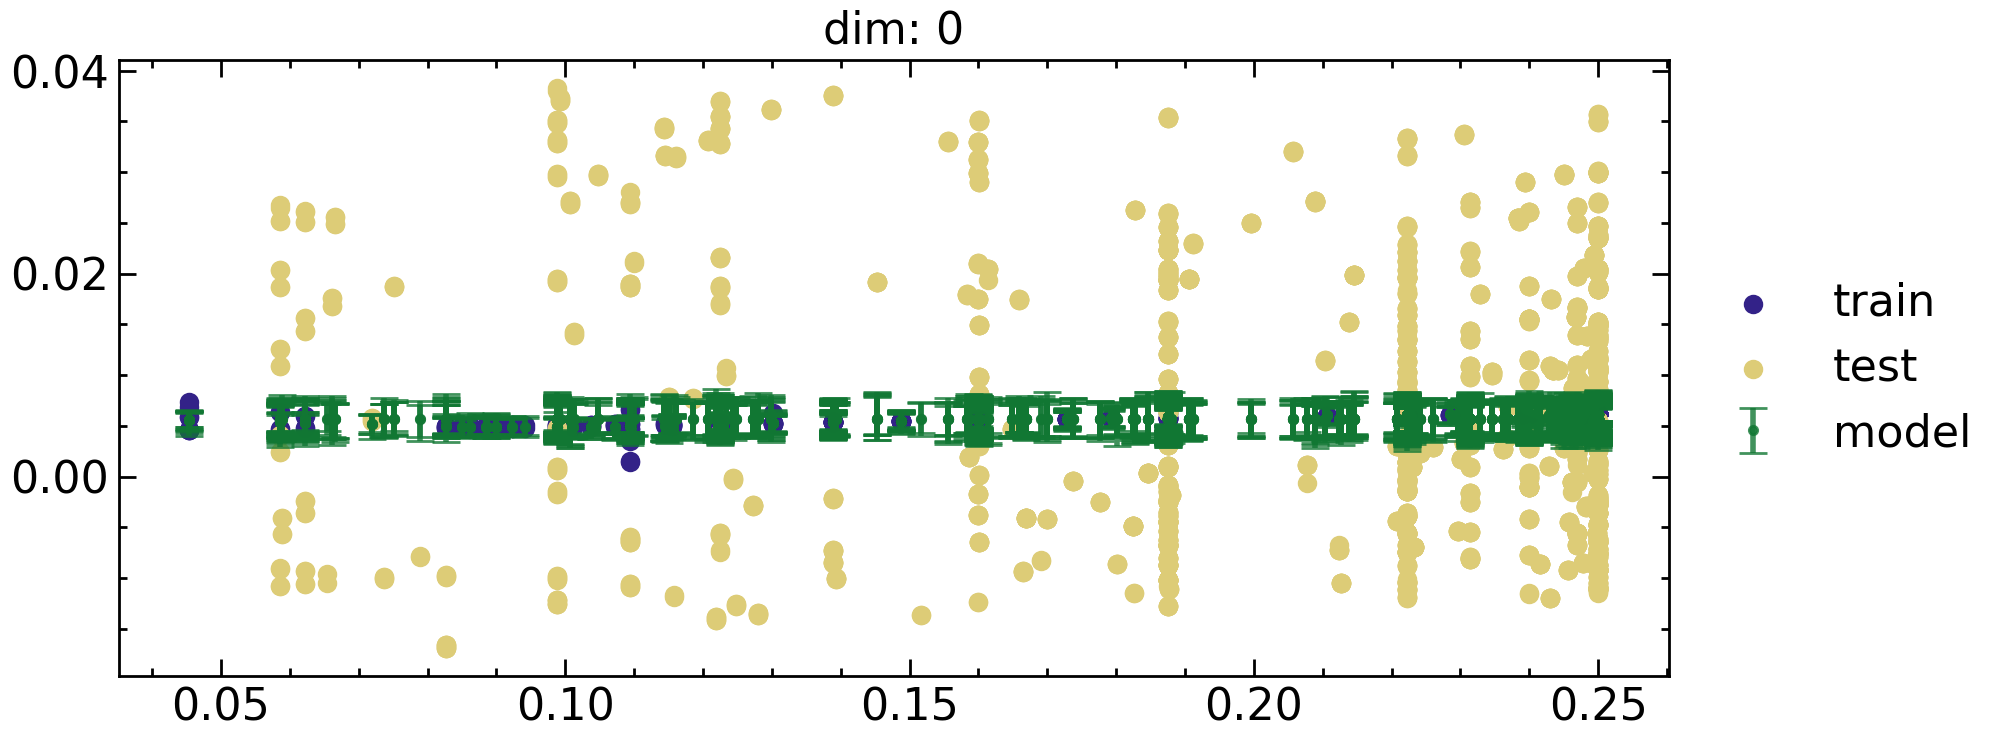

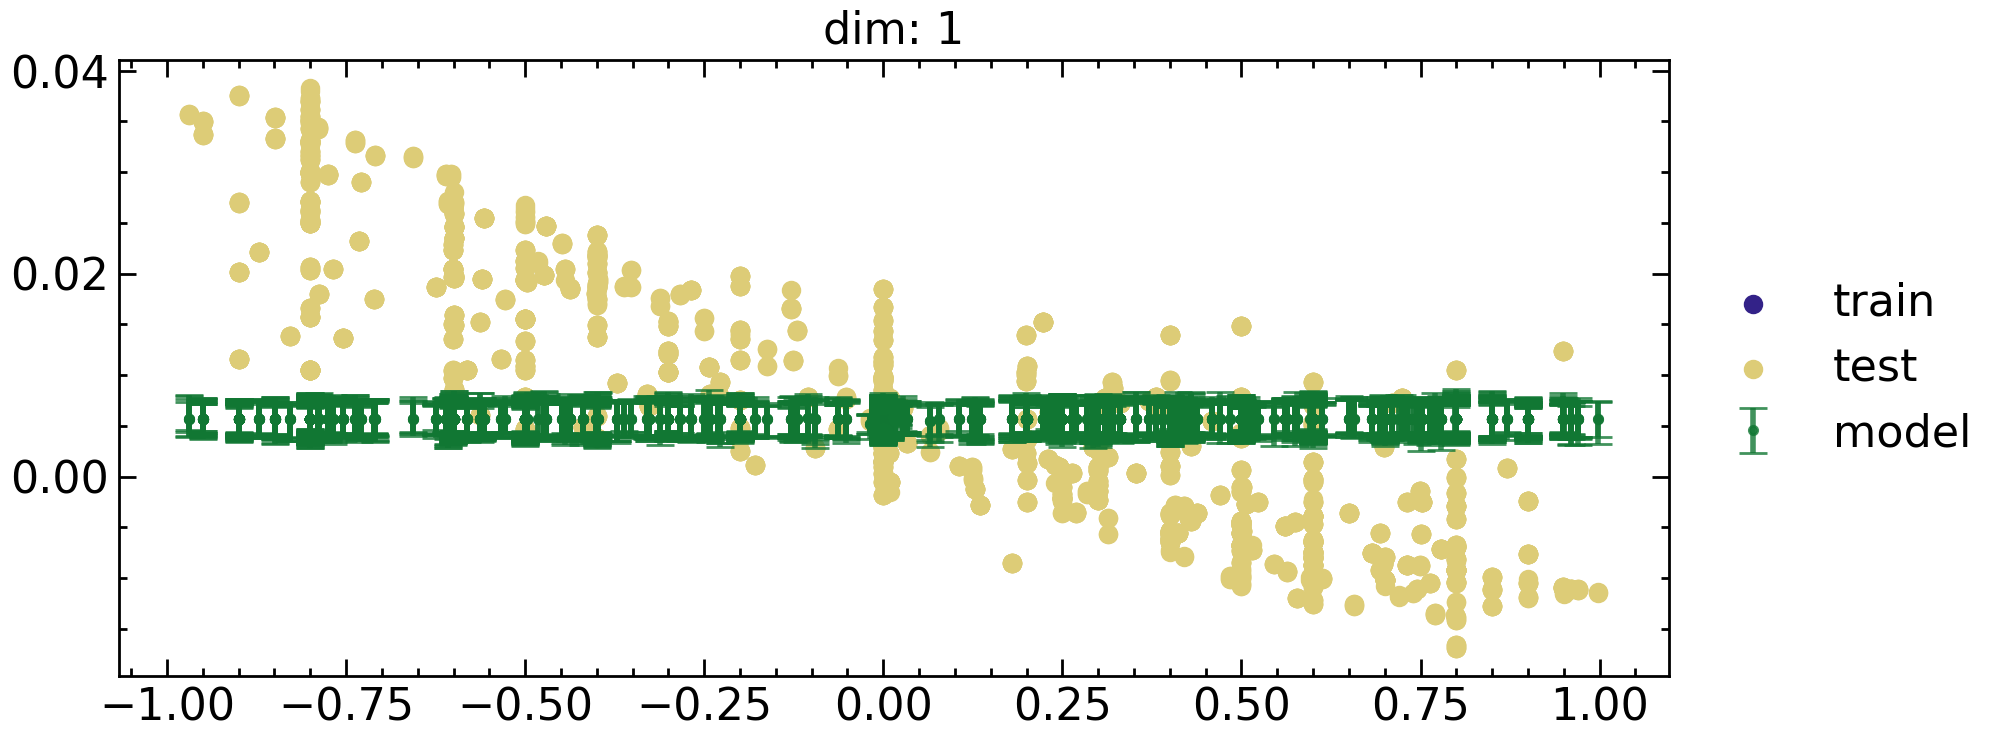

In [1710]:
for j in range(X.shape[1]):
    plt.figure(figsize=(10, 4), dpi=200)
    plt.title(f"dim: {j}")
    plt.scatter(X_train[:,j], y_train, label='train', c='C1')
    plt.scatter(X_test[:,j], y_test, label='test', c='C2')
    # plt.scatter(X[:,j], pred, fc='none', ec='C2', label='model')
    
    # for i in range(pred_samples.shape[1]):
    #     plt.scatter(X[:,j], pred_samples[:,i], fc='none', ec='C2', alpha=0.05)

    yerr = [pred_samples.max(1)-pred, pred-pred_samples.min(1)]
    plt.errorbar(X[:,j], pred, fmt='.C3', yerr=yerr, alpha=0.8, capsize=5, capthick=1, label='model')
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()

In [1711]:
X

array([[ 1.22478141e-01, -4.00075118e-01, -7.99055771e-01],
       [ 2.47877229e-01,  3.90150309e-01, -4.79875259e-01],
       [ 2.50000000e-01,  8.99737308e-01,  8.99737302e-01],
       ...,
       [ 2.50000000e-01,  1.99950923e-01, -5.20207408e-05],
       [ 9.87942469e-02, -6.03631991e-01, -7.52452418e-01],
       [ 2.50000000e-01, -5.99968038e-01, -1.02573826e-05]])

In [1766]:
X_non_spinning = np.zeros(shape=(100, 3))
X_non_spinning[:,0] = np.linspace(0.3, 0.001, 100)

In [1767]:
pred_fine, pstd_fine = gpr.predict(X_non_spinning, return_std=True, return_cov=False)

In [1768]:
train_mask_non_spinning = (np.abs(X_train[:,1]) < 1e-3) & (np.abs(X_train[:,2]) < 1e-3)
test_mask_non_spinning = (np.abs(X_test[:,1]) < 1e-3) & (np.abs(X_test[:,2]) < 1e-3)

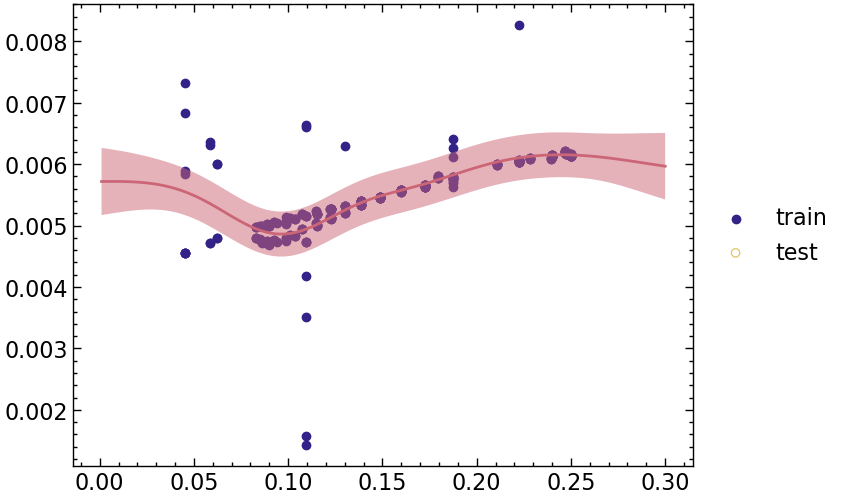

In [1769]:
plt.scatter(X_train[train_mask_non_spinning,0], y_train[train_mask_non_spinning], label='train', c='C1')
plt.scatter(X_test[test_mask_non_spinning,0], y_test[test_mask_non_spinning], label='test', ec='C2', fc='none')
plt.plot(X_non_spinning[:,0], pred_fine)
plt.fill_between(X_non_spinning[:,0], pred_fine - pstd_fine, pred_fine + pstd_fine, alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [1803]:
# https://scikit-learn.org/1.5/auto_examples/ensemble/plot_gradient_boosting_quantile.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-quantile-py
from sklearn.ensemble import GradientBoostingRegressor
all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    # max_depth=8,
    # min_samples_leaf=9,
    # min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

In [1807]:
from sklearn.metrics import mean_pinball_loss, mean_squared_error
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint

param_grid = dict(
    learning_rate=[0.05, 0.1, 0.2],
    max_depth=[2, 5, 10],
    min_samples_leaf=[1, 5, 10, 20],
    min_samples_split=[5, 10, 20, 30, 50],
)
alpha = 0.05
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss
)
gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, random_state=0)
search_05p = HalvingRandomSearchCV(
    gbr,
    param_grid,
    resource="n_estimators",
    max_resources=250,
    min_resources=50,
    scoring=neg_mean_pinball_loss_05p_scorer,
    n_jobs=2,
    random_state=0,
).fit(X_train, y_train)
pprint(search_05p.best_params_)

from sklearn.base import clone

alpha = 0.95
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss
)
search_95p = clone(search_05p).set_params(
    estimator__alpha=alpha,
    scoring=neg_mean_pinball_loss_95p_scorer,
)
search_95p.fit(X_train, y_train)
pprint(search_95p.best_params_)

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 150}
{'learning_rate': 0.1,
 'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 150}


In [1808]:
all_models

{'q 0.05': GradientBoostingRegressor(alpha=0.05, learning_rate=0.05, loss='quantile',
                           n_estimators=200),
 'q 0.50': GradientBoostingRegressor(alpha=0.5, learning_rate=0.05, loss='quantile',
                           n_estimators=200),
 'q 0.95': GradientBoostingRegressor(alpha=0.95, learning_rate=0.05, loss='quantile',
                           n_estimators=200)}

Text(0.5, 1.0, 'no tuning')

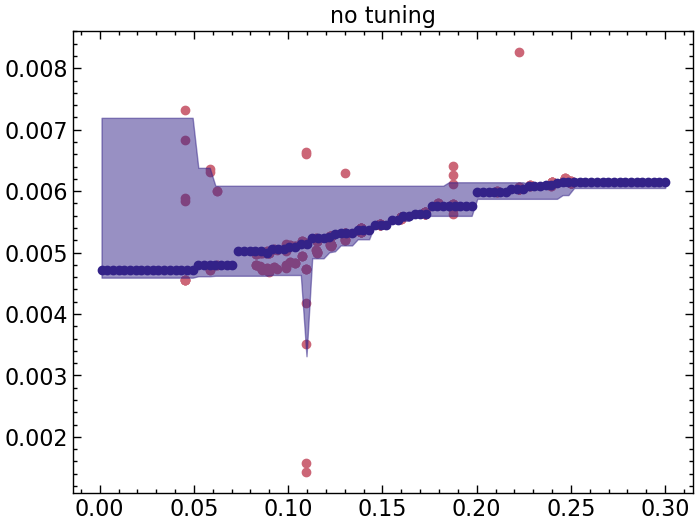

In [1811]:
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_non_spinning[:,0], all_models['q 0.50'].predict(X_non_spinning), color='C1')
plt.fill_between(X_non_spinning[:,0], all_models['q 0.05'].predict(X_non_spinning), all_models['q 0.95'].predict(X_non_spinning), alpha=0.5, color='C1')
plt.title('no tuning')

Text(0.5, 1.0, 'with tuning')

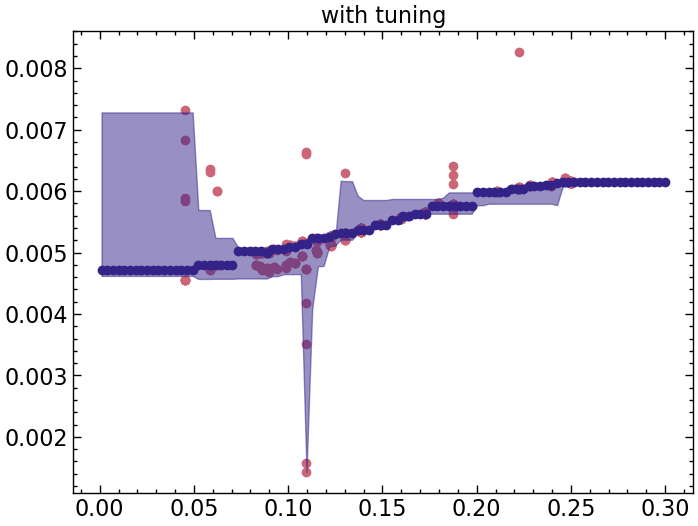

In [1810]:
y_lower = search_05p.predict(X_non_spinning)
y_upper = search_95p.predict(X_non_spinning)


plt.scatter(X_train[:,0], y_train)


plt.scatter(X_non_spinning[:,0], all_models['q 0.50'].predict(X_non_spinning), color='C1')
plt.fill_between(X_non_spinning[:,0], y_lower, y_upper, alpha=0.5, color='C1')

plt.title("with tuning")

In [1814]:
import sklearn.mixture

In [1870]:
gmm = sklearn.mixture.GaussianMixture(n_components=4).fit(X_train)

In [1871]:
logprob_thresh = gmm.score_samples(X_train).min()

In [1872]:
logprob_thresh

11.224743367323727

In [1873]:
logprobs_gmm = gmm.score_samples(X_non_spinning)

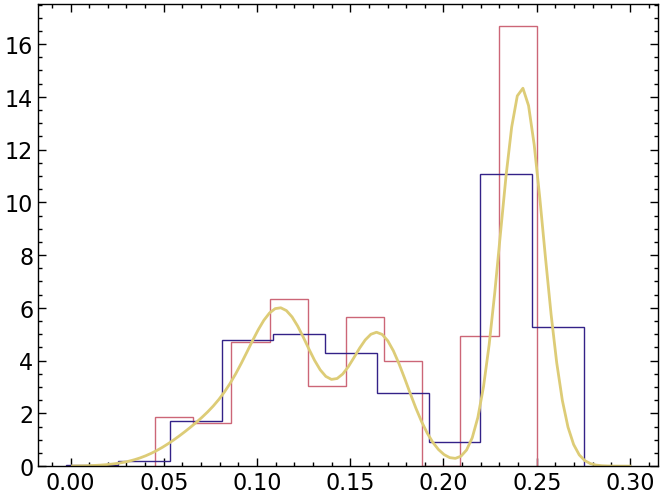

In [1874]:
plt.hist(X_train[:,0], density=True, histtype='step');
plt.hist(gmm.sample(1000)[0][:,0], density=True, histtype='step');
plt.plot(X_non_spinning[:,0], np.exp(logprobs_gmm)/1e6*6)

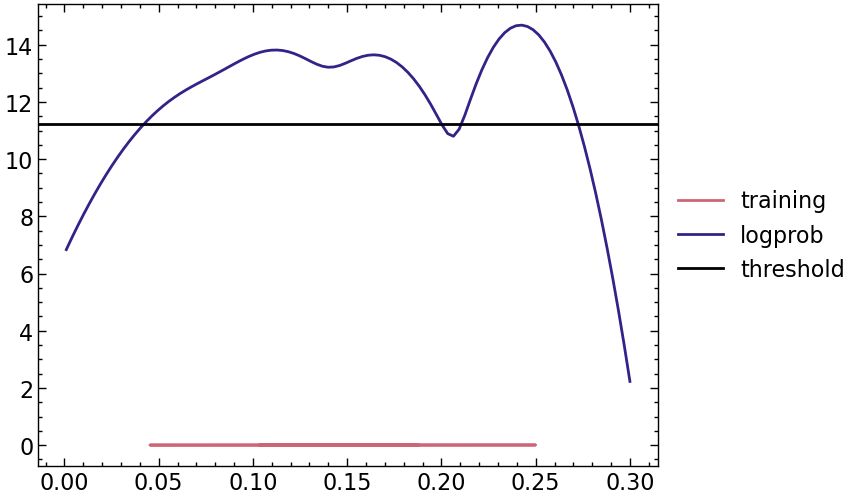

In [1887]:
plt.plot(X_train[:,0], y_train)
plt.plot(X_non_spinning[:,0], logprobs_gmm)
plt.axhline(logprob_thresh, c='k')
plt.legend(['training','logprob','threshold'], loc='center left', bbox_to_anchor=(1, 0.5))

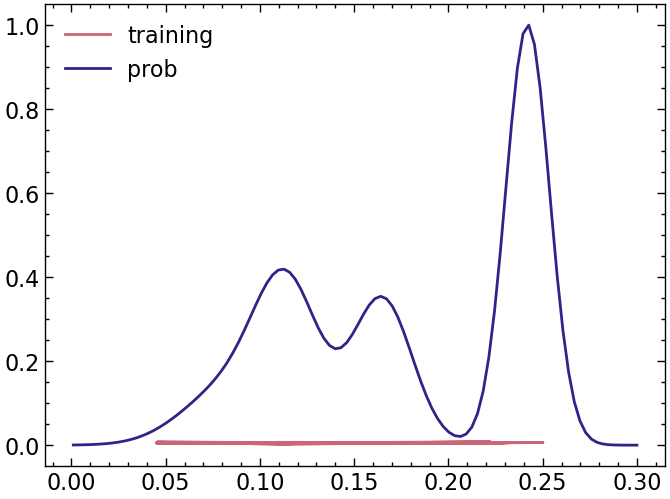

In [1886]:
plt.plot(X_train[:,0], y_train)
plt.plot(X_non_spinning[:,0], np.exp(logprobs_gmm)/np.exp(logprobs_gmm).max())
plt.legend(['training','prob','threshold'])

In [ ]:
# things to try
# SNGP ?
# MDN ? i.e. continous gaussian mixutre models for supervised learning.
# quantile-regression with trees

In [ ]:
kuhf

# fit data using rfflearn

In [1160]:
# Import rfflearn.
import rfflearn.cpu

In [1161]:
import sklearn.gaussian_process

In [1162]:
def fit_coeffs(X, y, dim_kernel=8, std_kernel=0.1):
    std_error = y_train.std()*5
    # gpr = rfflearn.cpu.RFFGPR(dim_kernel=dim_kernel, std_kernel=std_kernel, std_error=std_error)
    # gpr = rfflearn.cpu.ORFGPR(dim_kernel=dim_kernel, std_kernel=std_kernel, std_error=std_error)
    gpr = rfflearn.cpu.QRFGPR(dim_kernel=dim_kernel, std_kernel=std_kernel, std_error=std_error)
    gpr.fit(X, y)
    return gpr

In [1163]:
def fit_coeffs_sklearn(X, y, std_kernel=0.1):
    # std_error = y_train.std()
    # kfn = sklearn.gaussian_process.kernels.RBF(1.0 / std_kernel)
    # kfn = sklearn.gaussian_process.kernels.RBF()
    kfn = sklearn.gaussian_process.kernels.RationalQuadratic()
        # + sklearn.gaussian_process.kernels.WhiteKernel(std_error)
    gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel=kfn, normalize_y=True, alpha=1e-1)
    gpr.fit(X, y)
    return gpr

In [1164]:
q_fine = np.linspace(-1, 22, 100).reshape(-1, 1)

In [1165]:
X = df.iloc[idxs][['q']].values
y = coeffs[:,0]

gpr = fit_coeffs(X, y, 128, 0.1)
pred, pstd, pcov = gpr.predict(q_fine, return_std=True, return_cov=True)


In [1167]:
gpr_sk = fit_coeffs_sklearn(X, y, 0.1)
pred_sk, pstd_sk = gpr_sk.predict(q_fine, return_std=True, return_cov=False)

/home/sebastian.khan/.conda/envs/ppmhm/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


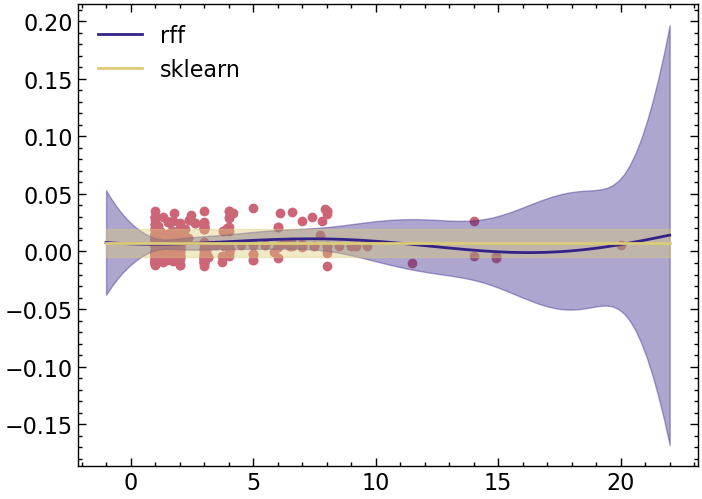

In [1168]:
plt.scatter(X, y)
plt.plot(q_fine, pred, c='C1', label='rff')
plt.fill_between(q_fine[:,0], pred-pstd, pred+pstd, alpha=0.4, color='C1')

plt.plot(q_fine, pred_sk, c='C2', label='sklearn')
plt.fill_between(q_fine[:,0], pred_sk-pstd_sk, pred_sk+pstd_sk, alpha=0.4, color='C2')

plt.legend()

# plt.ylim(-0.02,0.02)

In [1118]:
# optimisation

In [1119]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

In [784]:
Xscaler = sklearn.preprocessing.StandardScaler().fit(X_train)
yscaler = sklearn.preprocessing.StandardScaler().fit(y_train[:,np.newaxis])

X_train = Xscaler.transform(X_train)
X_test  = Xscaler.transform(X_test)

y_train = yscaler.transform(y_train[:,np.newaxis])[:,0]
y_test  = yscaler.transform(y_test[:,np.newaxis])[:,0]

In [785]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((263, 1), (131, 1), (263,), (131,))

In [786]:
import rfflearn.tuner

In [787]:
rfflearn.cpu.RFFGPR()

rfflearn.cpu.rfflearn_cpu_gp.RFFGPR

In [909]:
y_train.std()

1.0

In [911]:
study = rfflearn.tuner.RFF_dim_std_tuner(
    rfflearn.cpu.RFFGPR,
    train_set=(X_train, y_train),
    valid_set=(X_test, y_test),
    verbose=4,
    n_trials=1000,
    std_error=1,
    **{
        "dtype_dim_kernel": "int",
        "range_dim_kernel": {"low": 32, "high": 128},
        # "dtype_std_error" : "float",
        # "range_std_error" : {"low": 1e-4, "high": 5, "log": True},
        "dtype_std_kernel": "float",
        "range_std_kernel": {"low": 1e-3, "high": 5, "log": True}
    }
)

[I 2024-11-14 08:50:07,236] A new study created in memory with name: no-name-fa7e8433-bc16-45df-9c29-dd42cab809d0
[I 2024-11-14 08:50:07,245] Trial 0 finished with value: -0.015164335048210908 and parameters: {'dim_kernel': 101, 'std_kernel': 0.001217988235998474}. Best is trial 0 with value: -0.015164335048210908.
[I 2024-11-14 08:50:07,252] Trial 1 finished with value: 0.3082282103447713 and parameters: {'dim_kernel': 105, 'std_kernel': 0.19566014478900615}. Best is trial 1 with value: 0.3082282103447713.
[I 2024-11-14 08:50:07,256] Trial 2 finished with value: 0.30418086928587895 and parameters: {'dim_kernel': 45, 'std_kernel': 0.851064813177905}. Best is trial 1 with value: 0.3082282103447713.
[I 2024-11-14 08:50:07,262] Trial 3 finished with value: 0.3027887019870166 and parameters: {'dim_kernel': 73, 'std_kernel': 0.17853479906667707}. Best is trial 1 with value: 0.3082282103447713.
[I 2024-11-14 08:50:07,267] Trial 4 finished with value: 0.011973892973544675 and parameters: {'di

In [912]:
study

In [913]:
# Show the result of the hyper parameter tuning.
print("- study.best_params:", study.best_params)
print("- study.best_value:",  study.best_value)
print("- study.best_model:",  study.user_attrs["best_model"])

- study.best_params: {'dim_kernel': 65, 'std_kernel': 4.2879873427317925}
- study.best_value: 0.3145500551893393
- study.best_model: <rfflearn.cpu.rfflearn_cpu_gp.RFFGPR object at 0x7fcbcbbfb4f0>


In [914]:
import IPython

In [915]:
# # Create plotting contents, where
# #  - xs: parameter 1 (dim_kernel of RFFRegression)
# #  - ys: parameter 2 (std_kernel of RFFRegression)
# #  - zs: R2 score of the model.
# xs = np.array([trial.params["dim_kernel"] for trial in study.get_trials()])
# ys = np.array([trial.params["std_kernel"] for trial in study.get_trials()])
# zs = np.array([max(0, trial.value)        for trial in study.get_trials()])

# for idx in range(len(xs)):
#     plt.figure(figsize=(5, 4))
#     plt.title("Behavior of Hyper Parameter Tuning (step %3d/%3d)" % (idx + 1, len(xs)))
#     plt.xlabel("dim_kernel")
#     plt.ylabel("std_kernel")
#     plt.scatter(xs[:idx+1], ys[:idx+1], 20, zs[:idx+1], cmap="jet", vmin=0.5, vmax=0.8)
#     # plt.xlim((RANGE_DIM_KERNEL["low"], RANGE_DIM_KERNEL["high"]))
#     # plt.ylim((RANGE_STD_KERNEL["low"], RANGE_STD_KERNEL["high"]))
#     plt.yscale("log")
#     plt.colorbar()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.pause(0.1)
#     IPython.display.clear_output(wait=True)

In [916]:
study.user_attrs["best_model"]

In [919]:
q_fine_prime = Xscaler.transform(q_fine)

In [920]:
pred_prime, pstd_prime, pcov = study.user_attrs["best_model"].predict(q_fine_prime, return_std=True, return_cov=True)




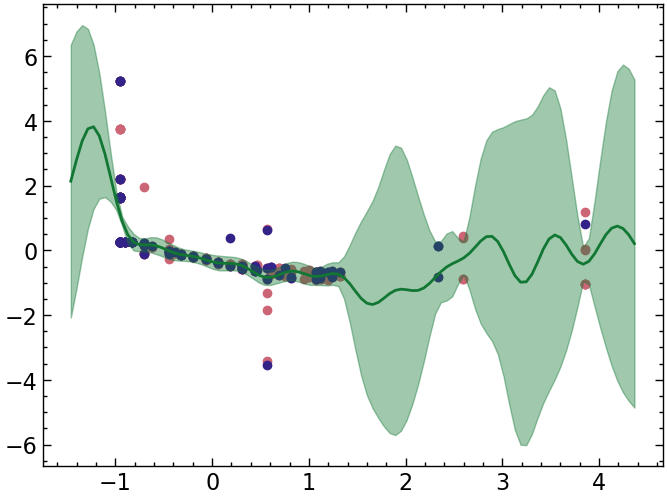

In [921]:
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)
plt.plot(q_fine_prime, pred_prime, color='C3')
plt.fill_between(q_fine_prime[:,0], pred_prime-pstd_prime, pred_prime+pstd_prime, alpha=0.4, color='C3')

In [930]:
pred = yscaler.inverse_transform(pred_prime[:,np.newaxis])[:,0]
pstd = yscaler.inverse_transform(pstd_prime[:,np.newaxis])[:,0]



In [934]:
plt.scatter(X, y)
plt.plot(q_fine, pred, c='C1', label='rff')
plt.fill_between(q_fine[:,0], pred-pstd, pred+pstd, alpha=0.4, color='C1')

# plt.plot(q_fine, pred_sk, c='C2', label='sklearn')
# plt.fill_between(q_fine[:,0], pred_sk-pstd_sk, pred_sk+pstd_sk, alpha=0.4, color='C2')

plt.legend()

# plt.ylim(-0.05,0.05)